# Class Activation Map (CAM)

This is one of many ways to visualize and get insights from a Convolutional Neural Network. What this basically does is that it creates a heatmap of "Class Activation" over the input image.  A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered. Quite simply, it tells us which features the model is looking for. Keras will be the deep framing framework that is going to be utilized. I am starting to really love Keras, its just so easy to use and as an effect saves a lot of time coding. If tensorflow was used for this project it would have taken longer because tensorflow is not rich in helper functions. Everything that is needed for this are all in Keras.

There are a lot of interesting insights from the model that are shown towards the end of this exercise.

In [145]:
# Upload your file! 
from google.colab import files
files.upload()

Saving bird.jpg to bird (1).jpg


{'bird.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x06?\t`\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x01\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x05\x03\x04\x06\x07\x08\xff\xc4\x00I\x10\x00\x02\x01\x03\x03\x03\x03\x02\x04\x02\x08\x04\x06\x00\x02\x0b\x00\x01\x02\x03\x11A\x04!1\x05Q\x81\x12aq\x06\x13\x14"2\x91B\xa1\x07#Rb\xb1\xc1\xd1\xf0\x153C\xe1\x16$Sr\x82\x92\xf1%\x174c&s\xc26DT\xa2\xb2\xff\xc4\x00\x1a\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x002\x11\x01\x01\x00\x02\x02\x03\x00\x02\x02\x02\x01\x03\x04\x02\x01\x05\x00\x01\x02\x11!1\x03\x12A\x1

## Line-by-Line Walkthrough

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

### For this exercise we will be using the VGG16 model

In [0]:
model = VGG16(weights='imagenet')

In [0]:
model = InceptionResNetV2(weights='imagenet')

### Sample Image

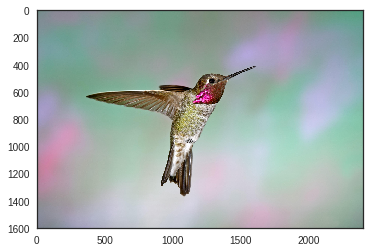

In [173]:
img_path = '/content/bird.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

### Resizing image to fit the input size of VGG

In [174]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))

<class 'PIL.Image.Image'>


In [0]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(299, 299))

### Convert to numpy array

In [0]:
x = image.img_to_array(img)

### Reshape data so that it is in "batch" form because the model only accepts input in this form

In [0]:
import numpy as np
x = np.expand_dims(x, axis=0)

### "Batch" form

In [0]:
x.shape

(1, 299, 299, 3)

### Preprocessing

In [0]:
from keras.applications.inception_resnet_v2 import preprocess_input
x = preprocess_input(x)

In [0]:
x

array([[[[-0.15294117,  0.09019613,  0.02745104],
         [-0.1372549 ,  0.10588241,  0.05882359],
         [-0.09803921,  0.11372554,  0.07450986],
         ...,
         [-0.3490196 ,  0.23921573,  0.00392163],
         [-0.35686272,  0.2313726 , -0.00392157],
         [-0.3333333 ,  0.23921573,  0.01176476]],

        [[-0.11372548,  0.09803927,  0.04313731],
         [-0.11372548,  0.09803927,  0.05882359],
         [-0.0745098 ,  0.12156868,  0.09019613],
         ...,
         [-0.3490196 ,  0.23921573,  0.00392163],
         [-0.3490196 ,  0.23921573,  0.00392163],
         [-0.3333333 ,  0.254902  ,  0.0196079 ]],

        [[-0.11372548,  0.09803927,  0.04313731],
         [-0.10588235,  0.10588241,  0.06666672],
         [-0.09803921,  0.09803927,  0.06666672],
         ...,
         [-0.3333333 ,  0.254902  ,  0.0196079 ],
         [-0.3490196 ,  0.23921573,  0.00392163],
         [-0.3333333 ,  0.254902  ,  0.0196079 ]],

        ...,

        [[-0.01176471,  0.03529418,  0

### Prediction

In [178]:
import pandas as pd
from keras.applications.inception_resnet_v2 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])

PREDICTION: redshank


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Top 3 Predictions:')

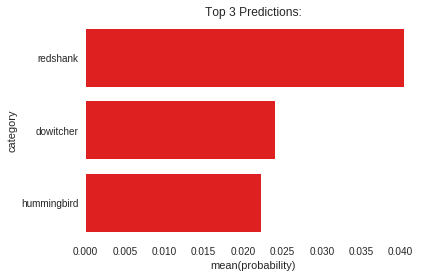

In [179]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Index of the prediction

In [0]:
argmax = np.argmax(preds[0])

### Get the index of the prediction

In [0]:
output = model.output[:, argmax]

### Model Archtecture

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

### We want to get the final Convolutional Layer

In [0]:
last_conv_layer = model.get_layer('block5_conv3')

In [0]:
last_conv_layer = model.get_layer('conv_7b')

### Get the Gradient

In [0]:
grads = K.gradients(output, last_conv_layer.output)[0]

### Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. This has a shape of (512,)

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

### Access the values of the quantities we just defined

In [0]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

### These are the values of these two quantities, as Numpy arrays, given our sample image of two elephants

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

### We multiply each channel in the feature map array by "how important this channel is" with regard to the elephant class

In [0]:
n_feature_maps = 512
for i in range(n_feature_maps):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Plotting the Heatmap

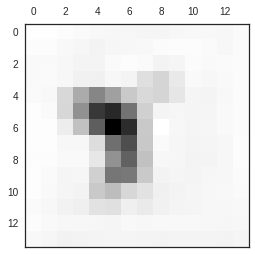

In [234]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Load Image with CV2

In [0]:
import cv2
img = cv2.imread(img_path)

### Resize the heatmap

In [0]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

### Convert heatmap to RGB

In [0]:
heatmap = np.uint8(255 * heatmap)

### Apply heatmap to original Image

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


### Apply heatmap intensity factor

In [0]:
hif = .8

In [0]:
superimposed_img = heatmap * hif + img

In [242]:
super_img = np.uint8(superimposed_img)
super_img.dtype, np.unique(super_img)

(dtype('uint8'),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 1

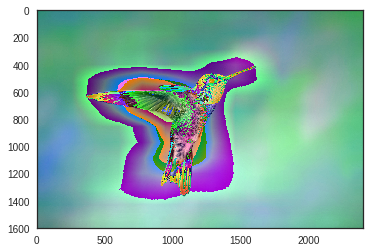

In [243]:
image = PIL.Image.fromarray(super_img, mode = 'RGB')
plt.imshow(image)

### Save to disk

In [0]:
output = '\content\output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

In [245]:
!ls

'bird (1).jpg'	 bird.jpg  '\content\output.jpeg'   output.png	 sample_data


### Plot

Text(0.5, 1.0, 'redshank')

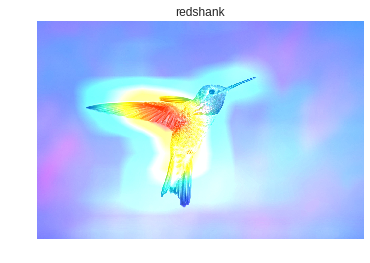

In [246]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

## Putting it all in a single funtion


### Cleaner Version

In [1]:
# For specifically imagenet-like images
import cv2
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
import PIL
import numpy as np
%matplotlib inline
from keras.preprocessing import image
K.clear_session()

def cam_heatmap(x, model, last_conv):
    """
    Computes the class activation heatmap from a model and its predictions.
    Args:
        x: preprocessed numpy array representing the image
        model: keras Model instance
        last_conv: str representing the name of the last convolutional layer OR an int representing the location of the last conv layer
        (before max-pooling, dense, or activation layer)
    Returns:
        heatmap
    """
    # prediction
    preds = model.predict(x)
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    # actually calculating the heatmap
    # fetching the last conv layer
    if isinstance(last_conv, int):
        last_conv_layer = model.layers[last_conv]
    elif isinstance(last_conv, str):
        last_conv_layer = model.get_layer(last_conv)
    else:
        raise Exception("Please choose a compatible format for the parameter: last_conv.")

    n_feature_maps = last_conv_layer.output_shape[-1]
    # computing the gradients
    grads = K.gradients(output, last_conv_layer.output)[0]
    # computing the mean gradient intensity over each feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    # access the variables we defined (by creating a composition function)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    # applying the function to the provided numpy array
    pooled_grads_value, conv_layer_output_value = iterate([x])
    # multiplying each channel in the feature map array by "how important this channel is" with regard to the elephant class
    for i in range(n_feature_maps):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # filtering the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def _convert_heatmap_to_rgb(heatmap, shape):
    """
    Converts the heatmap to RGB and resizes it to the desired shape
    Args:
      heatmap: numpy array
      shape: the shape to resize to
    """
    heatmap = cv2.resize(heatmap, (shape[1], shape[0]))
    # convert heatmap to rgb
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap

def _get_superimposed_img(image, heatmap, hif = 0.8):
    """
    Gets the resulting image after the heatmap is overlayed over the desired image
    Args:
        image: numpy array
        heatmap: numpy array (same shape as image)
        hif: the heat intensity factor (default: 0.8)
    Returns:
        the superimposed image
    """
    # applying a heat intensity factor
    return heatmap * hif + image

def visualize_heatmap(image, heatmap, output_path = None):
    """
    Shows an overlay of the heatmap on the image.
    Args:
        image: numpy array
        heatmap: numpy array
        output_path: str representing the output path (including the filename) (optional; default: None)
            * The outputted image looks better if you have an output_path because it gets to write and read from that file
    Returns:
        superimposed_img: the overlapped images
        A plot of the superimposed image
    """
    shape = image.shape
    heatmap = _convert_heatmap_to_rgb(heatmap, shape)
    superimposed_img = _get_superimposed_img(image, heatmap)
    if output_path is None:
        print("WARNING. It's likely that your outputted image is going to look weird. No worries, just specify a path for\n \
        `output_path` and it'll look normal.")
        pil_superimposed = PIL.Image.fromarray(np.uint8(superimposed_img), mode = 'RGB')
    elif output_path is not None:
        cv2.imwrite(output_path, superimposed_img)
        pil_superimposed = mpimg.imread(output_path)
    plt.imshow(pil_superimposed, cmap = 'jet') # output image looks a bit weird but watcha gonna do
    plt.axis('off')
    return superimposed_img


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


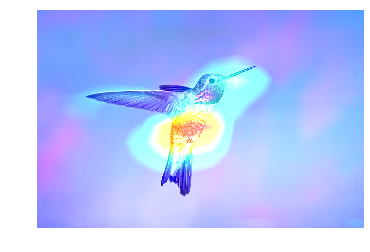

In [2]:
import keras.applications.vgg16 as vgg16
import keras.applications.inception_resnet_v2 as incep_resnet

img_path = '/content/bird.jpg'
model = 'vgg'

if model == 'vgg':
  model = vgg16.VGG16(weights='imagenet')
  target_size = (224, 224)
  last_conv = 'block5_conv3'
  preprocess_input = vgg16.preprocess_input
elif model == 'inceptionresnetv2':
  model = incep_resnet.InceptionResNetV2(weights='imagenet')
  target_size = (299, 299)
  last_conv = 'conv_7b'
  preprocess_input = incep_resnet.preprocess_input

# loading data + preprocessing
img = image.load_img(img_path, target_size = target_size) # loads as PIL image
x = image.img_to_array(img) #converts to numpy array
x = np.expand_dims(x, axis = 0) #converts to batch form
x = preprocess_input(x) # applies the corresponding preprocessing function
heatmap = cam_heatmap(x, model, last_conv)

actual_img = cv2.imread(img_path)
# computes the superimposed image and writes it to the output path.
super_temp = visualize_heatmap(actual_img, heatmap, output_path = '/content/outputted_image.png')

### Ugly Version

In [0]:
# For specifically imagenet-like images
import cv2
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
import PIL
%matplotlib inline
from keras.preprocessing import image
K.clear_session()

def cam(img_path, model, target_size, preprocess_fn, decode_fn, last_conv_layer, output_path = None):
  """
  Args:
    img_path:str representing where the image is
    model: 
    target_size:
    preprocess_fn:
  Returns:
    superimposed image
  """    
  # loading data + preprocessing
  img = image.load_img(img_path, target_size = target_size) # loads as PIL image
  x = image.img_to_array(img) #converts to numpy array
  x = np.expand_dims(x, axis=0) #converts to batch form
  x = preprocess_fn(x) # applies the corresponding preprocessing function
  # prediction 
  preds = model.predict(x)
  predictions = pd.DataFrame(decode_fn(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
  argmax = np.argmax(preds[0])
  output = model.output[:, argmax]
  
  # heatmap
  last_conv_layer = model.get_layer(last_conv_layer)
  n_feature_maps = last_conv_layer.output_shape[-1]
  grads = K.gradients(output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  for i in range(n_feature_maps):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
      
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = cv2.imread(img_path)
  print("Image shape: ", img.shape, x.shape)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  print("Heatmap final type: ", type(heatmap), "\nimage type: ", type(img))
  hif = .8
  superimposed_img = heatmap * hif + img
  print("Superimposed Shape: ", superimposed_img.shape, superimposed_img.dtype)
  if output_path is not None:
    cv2.imwrite(output_path, superimposed_img)
    superimposed_img = mpimg.imread(output_path)
  else:
    superimposed_img = PIL.Image.fromarray(np.uint8(superimposed_img), mode = 'RGB')
  plt.imshow(superimposed_img, cmap = 'jet')
  plt.axis('off')
  plt.title(predictions.loc[0,'category'].upper())
  plt.colorbar()
  return superimposed_img

Image shape:  (1599, 2400, 3) (1, 224, 224, 3)
Heatmap final type:  <class 'numpy.ndarray'> 
image type:  <class 'numpy.ndarray'>
Superimposed Shape:  (1599, 2400, 3) float64


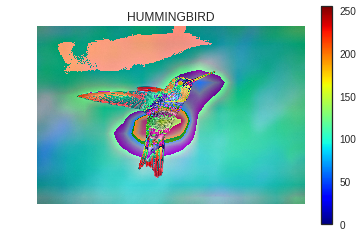

In [265]:
import keras.applications.vgg16 as vgg16
import keras.applications.inception_resnet_v2 as incep_resnet

img_path = '/content/bird.jpg'
model = 'vgg'
if model == 'vgg':
  model = vgg16.VGG16(weights='imagenet')
  target_size = (224, 224)
  last_conv = 'block5_conv3'
  preprocess_input = vgg16.preprocess_input
  decode_predictions = vgg16.decode_predictions
elif model == 'inceptionresnetv2':
  model = incep_resnet.InceptionResNetV2(weights='imagenet')
  target_size = (299, 299)
  last_conv = 'conv_7b'
  preprocess_input = incep_resnet.preprocess_input
  decode_predictions = incep_resnet.decode_predictions
heatmap = cam(img_path, model, target_size, preprocess_input, decode_predictions, last_conv, output_path =  None)#'/content/output.png')

## Other

### Trying it out on other images

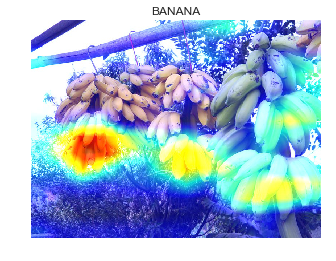

In [0]:
cam('G:/sample1.jpg')

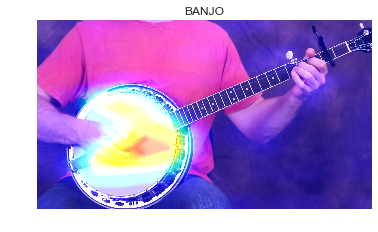

In [0]:
cam('G:/sample2.jpg')

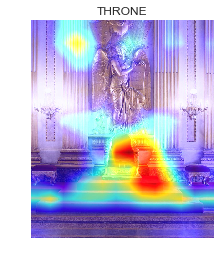

In [0]:
cam('G:/sample3.jpg')

### Using it on the same Category

As we expected, the CNN is looking for specific features. In the example below, when it sees this kind of nose/mouth area of a dog the models predicts that it is a greater swiss mountain dog.

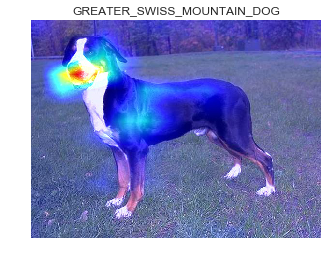

In [0]:
cam('G:/greater_swiss_mountain_dog.jpg')

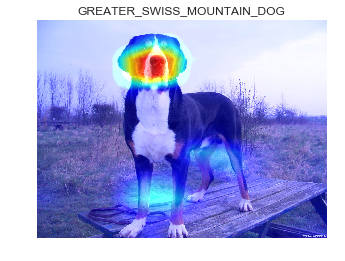

In [0]:
cam('G:/greater_swiss_mountain_dog4.jpg')

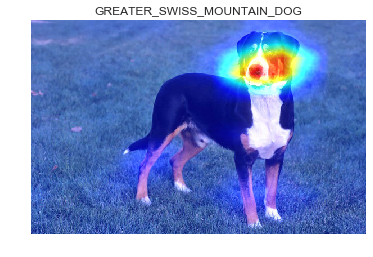

In [0]:
cam('G:/greater_swiss_mountain_dog2.jpg')

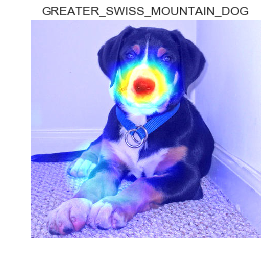

In [0]:
cam('G:/greater_swiss_mountain_dog3.jpg')

### Dogs

It is interesting what the model is looking for in order to identfy the breed of the dog.

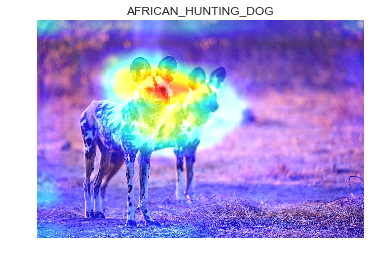

In [0]:
cam('G:/african_hunting_dog.jpg')

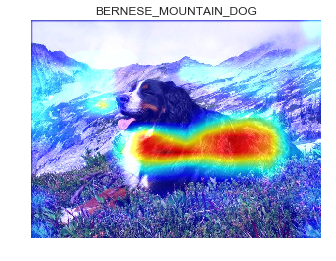

In [0]:
cam('G:/bernese_mountain_dog.jpg')

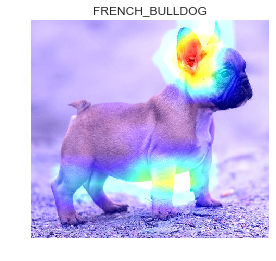

In [0]:
cam('G:/french_bulldog2.jpg')

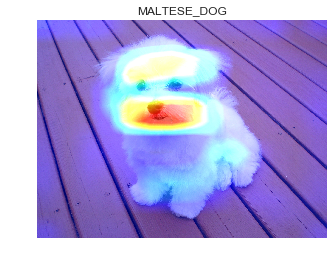

In [0]:
cam('G:/Maltese_puppy.jpeg')